In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.0
Running on TPU  ['10.76.240.138:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.76.240.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.240.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


<h2>Importing Libraries</h2>

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv("gdrive/My Drive/deep learning/Fake news-classifier/train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<h2>Data Cleaning</h2>

In [5]:
df.shape

(20800, 5)

In [6]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

<h2>Data Preprocessing</h2>

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
from IPython.display import clear_output
with tpu_strategy.scope():
  # creating objects for PorterStemmer, WordNetLemmatizer
  # from IPython.display import clear_output
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()
  # array to store the sentences after removing all the stopwords
  corpus = []
  count = 0
  # removing all the stopwords from each sentences
  for i in df['text'].values:
      print(count)
      sentences = re.sub('[^a-zA-Z]', ' ', i)
      sentences = sentences.lower()
      sentences = sentences.split()
      sentences = [lemmatizer.lemmatize(word) for word in sentences if not word in set(stopwords.words('english'))]
      sentences = " ".join(sentences)
      corpus.append(sentences)
      count = count + 1
      clear_output()

In [22]:
pd.DataFrame(corpus).to_csv('gdrive/My Drive/deep learning/Fake news-classifier/corp.csv')

In [11]:
df = pd.read_csv('gdrive/My Drive/deep learning/Fake news-classifier/corp.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,0
0,house dem aide even see comey letter jason cha...
1,ever get feeling life circle roundabout rather...
2,truth might get fired october tension intellig...
3,video civilian killed single u airstrike ident...
4,print iranian woman sentenced six year prison ...


In [12]:
df.shape

(18285, 1)

In [13]:
a = df['0'].values

In [14]:
len(a)

18285

In [15]:
corpus = []
for i in a:
    corpus.append(str(i))

In [16]:
len(corpus)

18285

In [17]:
# For the given problem we will consider the vocabulary size of 10000
vocab_size = 10000
# Now we will do the one-hot encoding of corpus sentences
oneHot = [one_hot(words, vocab_size) for words in corpus]

In [18]:
len(oneHot)

18285

In [19]:
maximum = 0
for i in oneHot:
    if len(i) > maximum:
        maximum = len(i)
print(maximum)

12059


In [20]:
# Embedding Representation
# Here we are considering sentence length of 20
sent_len = 13000
# Now we will make all the sentences of one standard length
embedded_docs = pad_sequences(oneHot, padding = 'pre', maxlen = sent_len)
print(embedded_docs[:5])

[[   0    0    0 ...  139 4023 8874]
 [   0    0    0 ... 8483 3700 4830]
 [   0    0    0 ... 4857 6482 3303]
 [   0    0    0 ... 9051 9684 2301]
 [   0    0    0 ... 6643 2687 7208]]


In [21]:
len(embedded_docs)

18285

<h2>Data Modeling</h2>

<h3>DNN-LSTM Model<h3>

In [22]:
# preparing x and y for our model
df_train = pd.read_csv("gdrive/My Drive/deep learning/Fake news-classifier/train.csv")
df_train = df_train.dropna()
x = np.array(embedded_docs)
y = df_train['label'].values

In [23]:
# displaying shapes of x and y 
print(x.shape, y.shape)

(18285, 13000) (18285,)


In [24]:
# Dividing the dataset into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(14628, 13000) (3657, 13000) (14628,) (3657,)


In [25]:
with tpu_strategy.scope():
  # model creation
  # total features for our model will be 40
  embedding_features = 40
  # here we are considering sequential model
  model = Sequential()
  # adding layers to the model
  model.add(Embedding(vocab_size, embedding_features, input_length = sent_len))
  model.add(Dropout(0.3))
  # adding LSTM layer
  model.add(LSTM(100))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13000, 40)         400000    
_________________________________________________________________
dropout (Dropout)            (None, 13000, 40)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
with tpu_strategy.scope():
  history = model.fit(x_train, y_train, validation_split = 0.20, shuffle = True, epochs = 10, batch_size = 128)

Epoch 1/10
92/92 [==============================] - 56s 522ms/step - loss: 0.5608 - accuracy: 0.6913 - val_loss: 0.2077 - val_accuracy: 0.9207
Epoch 2/10
92/92 [==============================] - 28s 306ms/step - loss: 0.1486 - accuracy: 0.9517 - val_loss: 0.1904 - val_accuracy: 0.9327
Epoch 3/10
92/92 [==============================] - 28s 306ms/step - loss: 0.1304 - accuracy: 0.9626 - val_loss: 0.1959 - val_accuracy: 0.9375
Epoch 4/10
92/92 [==============================] - 28s 306ms/step - loss: 0.0562 - accuracy: 0.9829 - val_loss: 0.2273 - val_accuracy: 0.9146
Epoch 5/10
92/92 [==============================] - 28s 306ms/step - loss: 0.0569 - accuracy: 0.9843 - val_loss: 0.2556 - val_accuracy: 0.9313
Epoch 6/10
92/92 [==============================] - 28s 306ms/step - loss: 0.0378 - accuracy: 0.9900 - val_loss: 0.2313 - val_accuracy: 0.9289
Epoch 7/10
92/92 [==============================] - 28s 306ms/step - loss: 0.0242 - accuracy: 0.9935 - val_loss: 0.3070 - val_accuracy: 0.9310

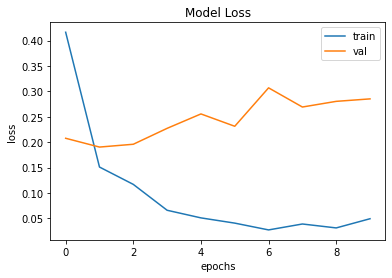

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["train", "val"], loc ="upper right")
# plt.legend(['train', 'val'], loc = ['upper left'])
plt.show()

<h2>Performance Metrics and Accuracy</h2>

In [28]:
y_pred = model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print("Accuracy score: ", ac)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score:  0.9237079573420837


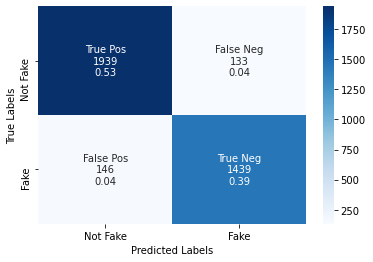

In [29]:
# Confusion matrix
group_names = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
group_counts = cm.flatten()
group_percentages = np.round(cm.flatten()/sum(cm.flatten()), 2)
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
 zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()